#### Try to get better correlations with looking around a vehicle count measure station and take temperature measuring stations nearest to it instead of dividing basel in squares and looking for stations of both lying in them

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.patches as ptc
import os
import ast
import datetime as dt

import imageio
from scipy.interpolate import griddata
from scipy.interpolate import interp2d

import math

from functions import vals_to_boxes as boxes

In [2]:
temperature = pd.read_csv("datasets/luftklima_reformatted.csv")
vehicles = pd.read_csv("datasets/verkehrszählungen_reformatted.csv")
sdf = pd.read_csv("datasets/strassen.csv", delimiter=";")

In [3]:
box = [7.5554, 7.6240, 47.5342, 47.5815]
x_min = box[0]
x_max = box[1]
y_min = box[2]
y_max = box[3]

In [4]:
spoints = sdf["Geo Shape"]
start = spoints[0].find("[")
spoints = spoints.apply(lambda x: x[start:-1])

In [5]:
basel = plt.imread("maps/basel_square_bw.jpg")

In [6]:
# define function for plotting streets
def plot_streets(zorder=0, rainbow=False, color="red", alpha=1.0):
    label="speed limit ≥ 50km/h"
    for row in spoints:
        # from string to array
        lst = ast.literal_eval(row)
        npa = np.array(lst).T
        x = npa[0, :]
        y = npa[1, :]
        
        if rainbow:
            plt.plot(x, y, zorder=zorder, alpha=alpha, label=label)
            label=None
        else:
            plt.plot(x, y, zorder=zorder, c=color, alpha=alpha, label=label)
            label=None

In [7]:
def plot_stations(df, col_name, color="Blue", size=10, zorder=0, alpha=1, label="Measuring Stations", marker="o"):
    uni = df[col_name].unique()
    x = []
    y = []
    for point in uni:
        x.append(float(point.split(",")[1]))
        y.append(float(point.split(",")[0]))
    plt.scatter(x, y, label=label, c=color, s=size, zorder=zorder, alpha=alpha, marker=marker)

In [8]:
vehicles["Geo Point"].unique()

array(['47.5751385212,7.56315796773', '47.5707346457,7.58226721123',
       '47.5739067576,7.60221558365', '47.5747982039,7.56235975514',
       '47.544580317,7.58621009181', '47.5427356062,7.58499570186',
       '47.5952640302,7.65559694893', '47.5381329483,7.59973013355',
       '47.5451875415,7.6017439017', '47.5768609024,7.56734174237',
       '47.5454597631,7.59957932935', '47.5487720165,7.60074551669',
       '47.5665568071,7.59767325247', '47.5463002054,7.5956105688',
       '47.5741246781,7.57471395015', '47.5680940673,7.57380422434',
       '47.5676129884,7.57101717908', '47.5527116018,7.60459281521',
       '47.5582014188,7.59753472493', '47.5811860062,7.60450160902',
       '47.5699125893,7.57284015165', '47.5771259757,7.59655916981',
       '47.5656137668,7.58805266441', '47.5520832984,7.58677034361',
       '47.5889260115,7.5931162086', '47.5499027851,7.58292410405',
       '47.5441806077,7.57712039374', '47.5621767136,7.56405911184',
       '47.5722888439,7.6239861801', '

In [9]:
vec_stats = vehicles["Geo Point"].unique()
temp_stats = temperature["Koordinaten"].unique()

In [10]:
len(vec_stats), len(temp_stats)

(32, 181)

In [35]:
def get_temp_for_vstation(time_from, time_to, radius):
    
    vehicles["hour"] = pd.to_datetime(vehicles["TimeFrom"], format="%H:%M").dt.strftime("%H").astype(int)
    vehicles["Datum"] = pd.to_datetime(vehicles["Date"], format="%d.%m.%Y").dt.strftime("%Y-%m-%d")
    temp = temperature[(temperature.Datum >= time_from) & (temperature.Datum <= time_to)]
    temp_here = temperature[(temperature.Datum >= time_from) & (temperature.Datum <= time_to)]
    veh = vehicles[(vehicles.Datum >= time_from) & (vehicles.Datum <= time_to)]
    veh_here = vehicles[(vehicles.Datum >= time_from) & (vehicles.Datum <= time_to)]
    
    veh_stats = veh["Geo Point"].unique()
    temp_stats = temp["Koordinaten"].unique()
    vx = []
    vy = []
    tx = []
    ty = []
    for point in veh_stats:
        vx.append(float(point.split(",")[1]))
        vy.append(float(point.split(",")[0]))
        
    for point in temp_stats:
        tx.append(float(point.split(",")[1]))
        ty.append(float(point.split(",")[0]))
        
    vn = len(veh_stats)
    tn = len(temp_stats)
    print(vn)
    print(tn)
    
    stats = [] # includes a set of nearby temp. measure stations for every vehicle count station
    
    for i in range(vn):
        stats_v = []
        for j in range(tn):
            if math.sqrt((vx[i] - tx[j])**2 + (vy[i] - ty[j])**2) < radius:
                stats_v.append((tx[j], ty[j]))
        stats.append(stats_v)
    
    time_from = dt.datetime.strptime(time_from, "%Y-%m-%d")
    time_to = dt.datetime.strptime(time_to, "%Y-%m-%d")
    delta_days = (time_to - time_from).days
    
    corr = []
    for s in stats:
        #v = 0
        num = 0
        date = time_from
        corr_v = []
        corr_t = []
        for i in range(delta_days):
            for h in range(24):
                
                hourly_stats_temp = temp_here[(temp_here.Datum == date.strftime("%Y-%m-%d")) & (temp_here.Stunde == h)]
                hourly_stats_veh = veh_here[(veh_here.Datum == date.strftime("%Y-%m-%d")) & (veh_here.hour == h)]

                temp = 0
                for stat in s:
                    #print(stat[0])
                    p = str(stat[1]) + "," + str(stat[0])
                    station = hourly_stats_temp[hourly_stats_temp["Koordinaten"] == p]
                    #print(station)
                    t = station["Lufttemperatur"].tolist()
                    #print(t.head())
                    if len(t) != 0:
                        temp += t[0]
                num += 1
                if len(s) > 0:
                    temp /= len(s)
                #print(temp, flush=True)

                p = str(vy[v]) + "," + str(vx[v])
                vc = hourly_stats_veh[hourly_stats_veh["Geo Point"] == p]
                vcs = vc["Total"].tolist()
                #print(vc)
                if len(vcs) != 0:
                    v_num = 0
                    v_count = 0
                    for k in range(len(vcs)):
                        v_count += vcs[k]
                        v_num += 1
                    v_count /= v_num
                else:
                    v_count = 0
                #print(v_count)
                
                corr_v.append(v_count)
                corr_t.append(temp)
                
        corr_v = np.array(corr_v)        
        corr_t = np.array(corr_t)      
        c = np.corrcoef(np.vstack([corr_v, corr_t]))
        corr.append(c[0][1])
            
        v += 1

    print(corr)
    return(vx, vy, corr)

In [36]:
corr = get_temp_for_vstation("2020-06-01", "2020-07-01", 0.004)

29
125
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN 1
LEN

KeyboardInterrupt: 

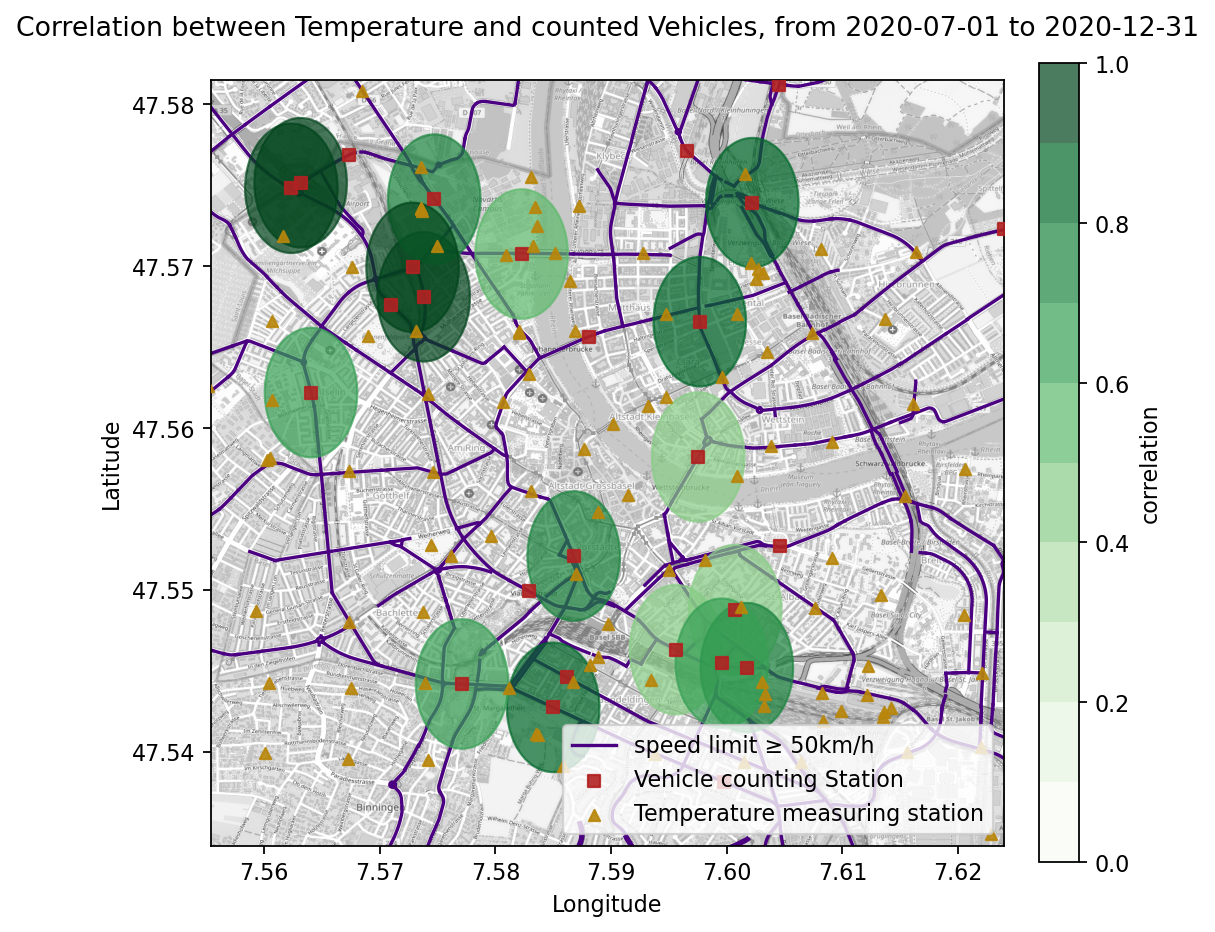

In [29]:
fig, ax = plt.subplots(figsize=(7, 7), dpi=160)
#plt.figure(figsize=(7, 7), dpi=160)

cmap = matplotlib.cm.get_cmap('Greens', 10)
norm = matplotlib.colors.Normalize(vmin=0.0, vmax=1.0)
circ = []
for i in range(len(corr[2])):
    if corr[2][i] > -999999999999: #get rid of NaN
        cir = plt.Circle((corr[0][i], corr[1][i]), 0.004, color=cmap(norm(corr[2][i])), fill = True, alpha=.7)
        circ.append(cir)
for c in circ:
     ax.add_artist(c)
        
plot_streets(zorder=1, color="indigo")        
plot_stations(vehicles, "Geo Point", zorder=3, size=25, color="firebrick", alpha=.9, label="Vehicle counting Station", marker=",")
plot_stations(temperature, "Koordinaten", zorder=3, size=25, color="darkgoldenrod", alpha=.9, label="Temperature measuring station", marker="^")
#plt.scatter(corr[0], corr[1], marker="o", zorder=1, c=corr[2], s=600)
plt.imshow(basel, extent=box, zorder=0, aspect=1.4, alpha=.7, cmap = matplotlib.cm.get_cmap('Greens', 10))
plt.colorbar(label="correlation", fraction=0.046, pad=0.04)
plt.clim((0, 1))
plt.title("Correlation between Temperature and counted Vehicles, from 2020-07-01 to 2020-12-31", pad=20)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc='lower right')
plt.show()